## Compute a lot of umaps

Also generates "word_pairs.pkl", which contains a benchmark of the cos dists between many word pairs.
These cos dists should be used to compare PCA, VAE, and UMAP in a future notebook.


In [122]:
import umap
import math
import dataclasses
import pickle
import random
import numpy as np
import os
import time
import multiprocessing
from joblib import Parallel, delayed
import re
from functools import lru_cache
from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import euclidean, pdist, squareform
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import cosine as cos_dist
from sklearn.preprocessing import normalize, StandardScaler
from gensim import models
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic
from typing import *

In [187]:
DATA_DIR = '/mnt/Spookley/datasets/semantle/'

In [66]:

def read_goog_file(size=None):
    vec_file = DATA_DIR + 'GoogleNews-vectors-negative300.bin'
    kv = models.KeyedVectors.load_word2vec_format(vec_file, binary=True, limit=size)
    words = kv.index_to_key
    w_vecs = {}
    good_word = re.compile(r'^[a-z]+$')
    for w in words:
        # filter out proper nouns, pictograms, emoji, multi-words, etc. Eliminates 95% of the dataset.   
        #if not good_word.match(w):
        #    continue
        
        w_vecs[w] = kv[w] / np.linalg.norm(kv[w])
    mat_full = np.array([w_vecs[w] for w in w_vecs])
    w_list = list(w_vecs.keys())
    return w_list, normalize(mat_full, axis=1)

w_list, mat_full_normed = read_goog_file(size=None)
mat_full_normed.shape

fn = DATA_DIR + 'w_list_{}.pkl'.format(mat_full_normed.shape[0])
if not os.path.isfile(fn):
    with open(fn, 'wb') as fh:
        pickle.dump(w_list, fh)

In [3]:
def do_pca(mat_full_normed, n_dims=10):
    pca = PCA(n_components=n_dims)
    mat = pca.fit_transform(mat_full_normed)
    return mat

In [4]:
def do_umap(mat_full_normed, nns=15, n_dims=10):
    reducer = umap.UMAP(
        n_neighbors=nns,
        min_dist=0.1,
        n_components=n_dims,
        metric='cosine',
        low_memory=True
    )
    return reducer.fit_transform(mat_full_normed)

def do_umap_sphere(mat_full_normed, nns=15):
    sphere_mapper = umap.UMAP(
        n_neighbors=nns,
        min_dist=0.1,
        metric='cosine',
        low_memory=True,
        output_metric='haversine'
    )
    return sphere_mapper.fit_transform(mat_full_normed)



In [5]:
# precompute many umaps
# 
# high mem times...
# 200K rows @ 5 nns:    67 seconds
#
# low mem times...
# 100K rows @ 15 nns:   30 seconds
# 200K rows @ 15 nns:   68 seconds
# 200K rows @ 5 nns:    64 seconds
# 400K rows @ 15 nns:  180  seconds
# OK, 3M rows should take ~20 mins.
t0 = time.time()
for d in [2, 3, 10, 30, 100]:
    for nns in [15, 50, 100, 1000]:
        nrows = mat_full_normed.shape[0]
        fn = 'umap_{}rows_{}dims_{}nns.npy'.format(nrows, d, nns)
        #fn = 'umap_{}rows_sphere_{}nns.npy'.format(nrows, nns)
        if os.path.isfile(fn):
            print('already have', fn)
        else:
            mat_umap = do_umap(mat_full_normed, nns=nns, n_dims=d)
            #mat_umap = do_umap_sphere(mat_full_normed, nns=nns)
            print(mat_umap.shape)
            np.save(DATA_DIR + fn, mat_umap)
            print('wrote', fn, 'at', round(time.time()-t0, 3))
            t0=time.time()

already have umap_155060rows_2dims_15nns.npy
already have umap_155060rows_2dims_50nns.npy
already have umap_155060rows_2dims_100nns.npy
already have umap_155060rows_2dims_1000nns.npy
already have umap_155060rows_3dims_15nns.npy
already have umap_155060rows_3dims_50nns.npy
already have umap_155060rows_3dims_100nns.npy
(155060, 3)
wrote umap_155060rows_3dims_1000nns.npy at 605.103
(155060, 10)
wrote umap_155060rows_10dims_15nns.npy at 52.481
(155060, 10)
wrote umap_155060rows_10dims_50nns.npy at 80.137
(155060, 10)
wrote umap_155060rows_10dims_100nns.npy at 121.706
(155060, 10)
wrote umap_155060rows_10dims_1000nns.npy at 594.63
(155060, 30)
wrote umap_155060rows_30dims_15nns.npy at 68.482
(155060, 30)
wrote umap_155060rows_30dims_50nns.npy at 93.994
(155060, 30)
wrote umap_155060rows_30dims_100nns.npy at 128.479
(155060, 30)
wrote umap_155060rows_30dims_1000nns.npy at 608.516
(155060, 100)
wrote umap_155060rows_100dims_15nns.npy at 115.564
(155060, 100)
wrote umap_155060rows_100dims_50nn

In [7]:
def cos_dist_in_original(w1: str, w2: str, w_list, mat):
    w1_idx = w_list.index(w1)
    w2_idx = w_list.index(w2)
    return cos_dist(mat[w1_idx, :], mat[w2_idx, :])

def eu_dist_in_pca(w1: str, w2: str, w_list, mat):
    w1_idx = w_list.index(w1)
    w2_idx = w_list.index(w2)
    return euclidean(mat[w1_idx, :], mat[w2_idx, :])

In [11]:
# Find a large set of word pairs that represents all cosine distances about evenly.
# If we just picked random pairs, we'd over-represent midrange distances.
# So we'll bin them by distance and keep the bin sizes about even.

@dataclasses.dataclass
class WordPair():
    w1: str
    w2: str
    dist: float
    
    def __str__(self):
        return '{} -> {}: {}'.format(self.w1, self.w2, self.dist)

def all_full(bins: dict, fill_to: int):
    return all(bins[k] >= fill_to for k in bins.keys())

def fill_bins(w1, w_list, fill_to=25):
    cutoffs = [0.6, 0.7, 0.8, 0.9, 1.0, 2.0]
    bins = dict(zip(cutoffs, [0]*len(cutoffs)))
    wps = []
    for w2 in random.sample(w_list, len(w_list)):
        dist = cos_dist_in_original(w1, w2, w_list, mat_full_normed)
        # put word pair in smallest bin, if it's not full
        for b in bins.keys():
            if dist < b:
                if bins[b] < fill_to:
                    wp = WordPair(w1=w1, w2=w2, dist=dist)
                    wps.append(wp)
                    bins[b] += 1
                break
        # check if we're done with this w1
        if all_full(bins, fill_to):
            break
    return wps


fn = DATA_DIR + 'word_pairs.pkl'
if os.path.isfile(fn):
    raise ValueError('File exists already')

word_pairs_cos = {}
w1s = ['banana', 'leaving', 'three', 'fortunate', 'electric', 'ended', 'swim', 
       'retch', 'flute', 'hands', 'trench', 'painful', 'airborne', 'safety', 'give',
       'never', 'ferocious', 'splitter', 'raccoon', 'pickle', 'microphone', 'love',
       'zombie', 'undulate', 'semicircle', 'book', 'doctor', 'arrow', 'fridge', 'merry',
       'crank', 'similar', 'flew', 'knock', 'neighbor', 'cell', 'cloud', 'moon', 'zebra',
       'therefore', 'abrupt', 'rend', 'knife', 'shill', 'dollar', 'spilled', 'carpet',
       'lunatic', 'beach', 'revert', 'future', 'nigh', 'drake', 'winded', 'play', 'freedom']


results = Parallel(n_jobs=10)(delayed(fill_bins)(w1, w_list) for w1 in w1s)
word_pairs_cos = []
for r in results:
    word_pairs_cos.extend(r)

with open(fn, 'wb') as fh:
    pickle.dump(word_pairs_cos, fh)

for wp in word_pairs_cos:
    print(wp)

banana -> insulated: 0.953282106667757
banana -> favourability: 0.9210276752710342
banana -> mineralising: 0.9518966265022755
banana -> launcher: 0.9161522462964058
banana -> demotivating: 1.0028560124337673
banana -> serostatus: 0.973596666008234
banana -> stimulated: 0.9019455462694168
banana -> unsustained: 0.8976513519883156
banana -> vogue: 0.9253203421831131
banana -> uni: 0.8077193200588226
banana -> theorise: 0.8781469315290451
banana -> poltics: 0.9263986423611641
banana -> accompaniers: 0.8950798213481903
banana -> florally: 0.738825649023056
banana -> rivets: 0.9572071805596352
banana -> pappi: 0.8451756983995438
banana -> midlake: 0.857432946562767
banana -> satrapy: 0.9519150741398335
banana -> exhaling: 0.9675441570580006
banana -> gameday: 0.9636515788733959
banana -> politicizing: 0.9677433371543884
banana -> steepness: 0.9497129768133163
banana -> solid: 0.9848707253113389
banana -> restabilize: 0.8840090110898018
banana -> hala: 0.7667342126369476
banana -> turbojets:

In [6]:
len(word_pairs_cos)

7000

In [16]:
def get_eu_dists(word_pairs_cos, w_list, mat):
    eu_dists = []
    for wp in word_pairs_cos:
        eu_dists.append(eu_dist_in_pca(wp.w1, wp.w2, w_list, mat))
    return eu_dists


In [185]:
def curve_func(x, p3, p2, p1):
    # scaled sigmoid positioned on x axis
    y = p3 / (1 + np.exp(-p2*(x-p1)))
    return y

def do_curve_fit(cos_dists, eu_dists):
    n_bins=50
    bin_means, bin_edges, binnumber = binned_statistic(cos_dists, eu_dists, statistic='median',bins=n_bins)
    bin_points = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(n_bins)]
    
    y = []
    for b in bin_means:
        if np.isnan(b):
            y.append(0.0)
        else:
            y.append(b)
    guess=[3.27002295, 6.27685011, 0.70386182]
    curve, _ = curve_fit(curve_func, bin_points, y, p0=guess)
    return bin_points, curve

# do_curve_fit(cos_dists, eu_dists)

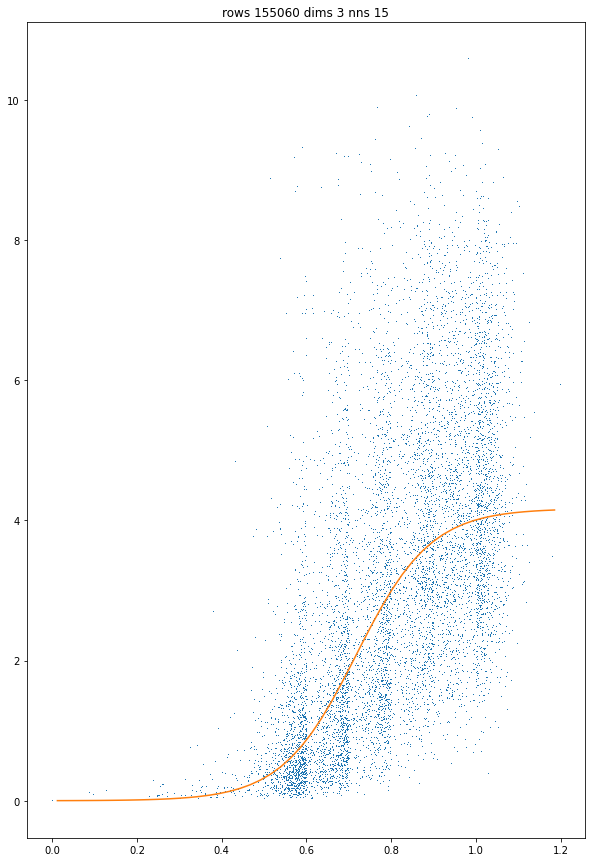

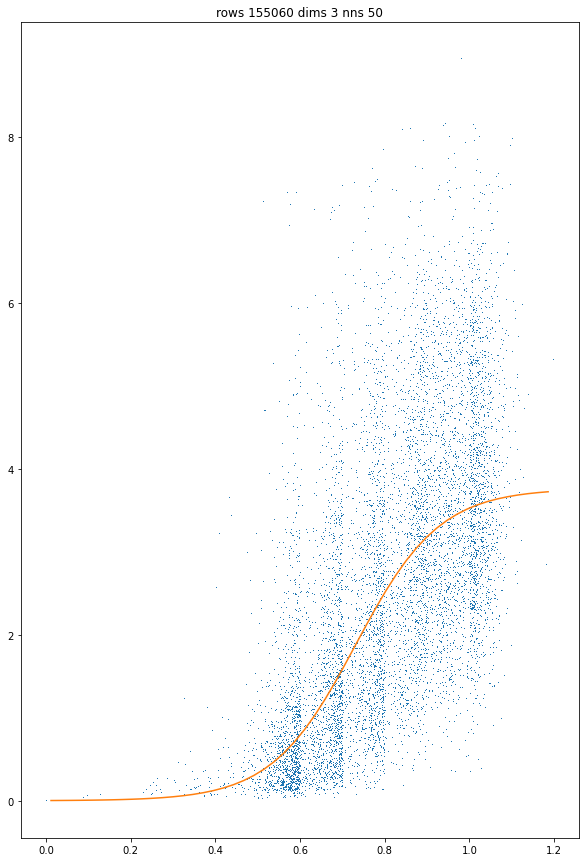

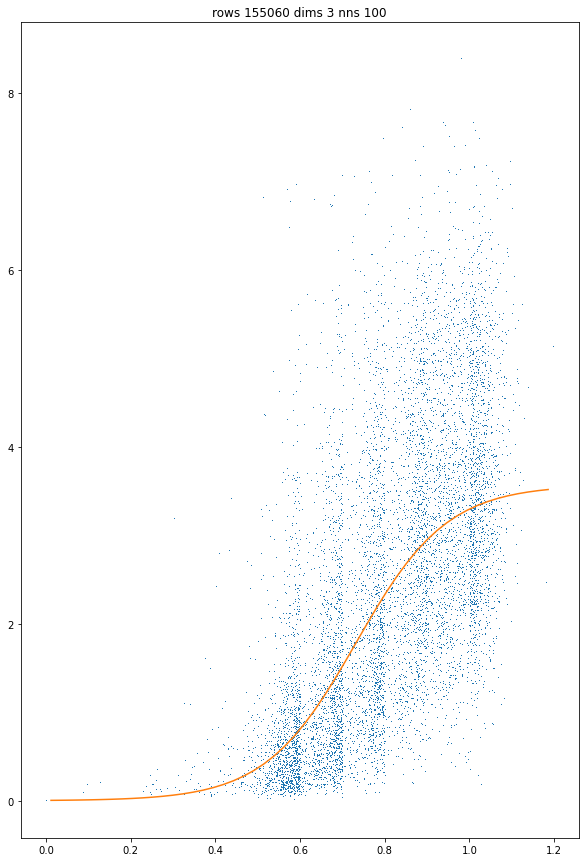

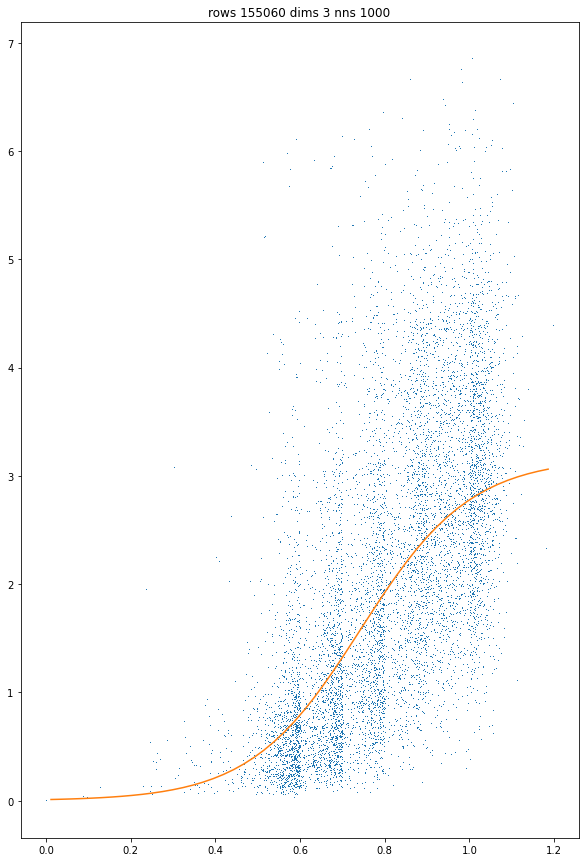

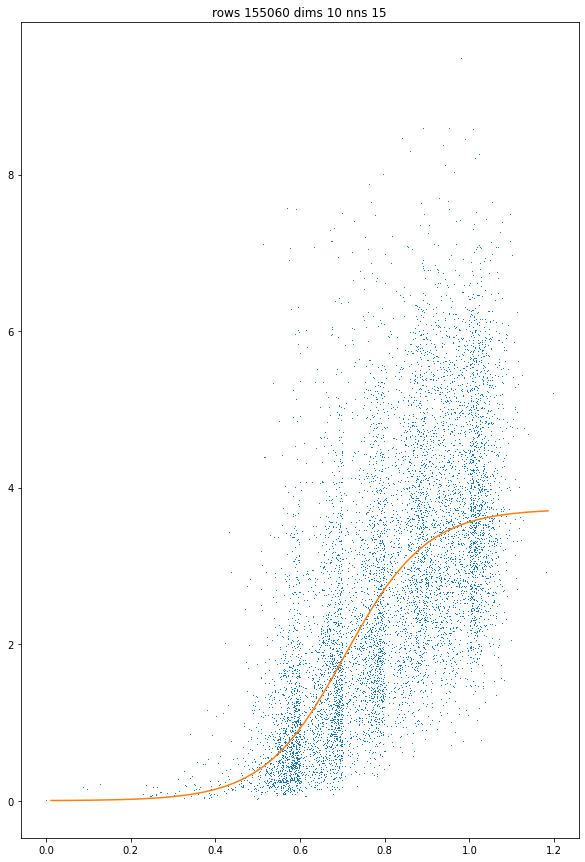

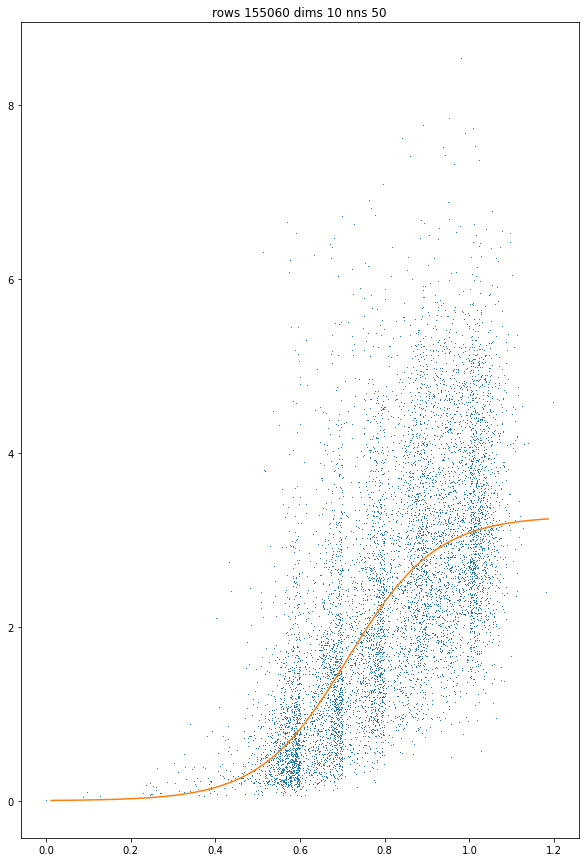

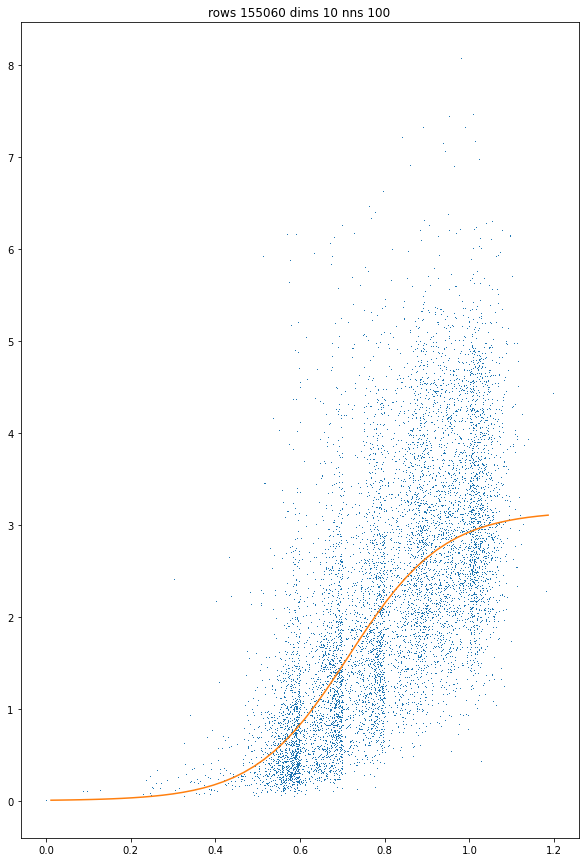

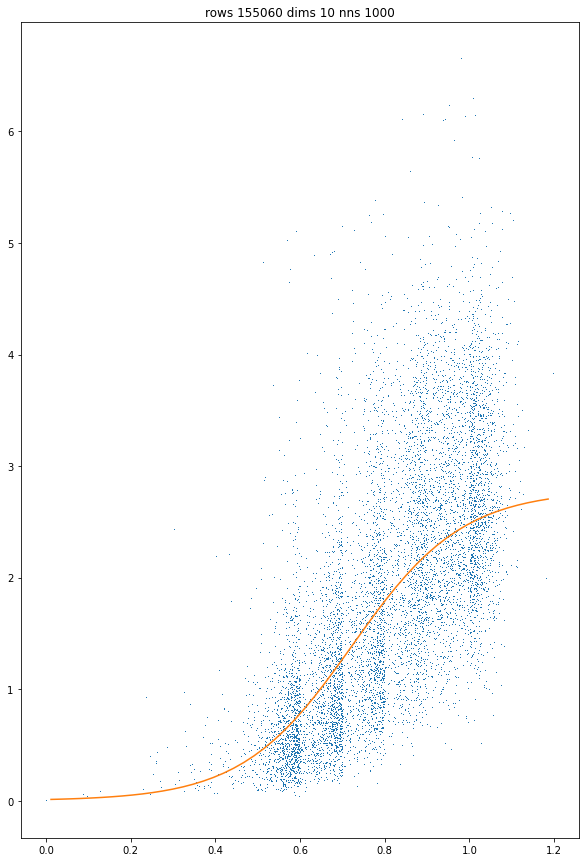

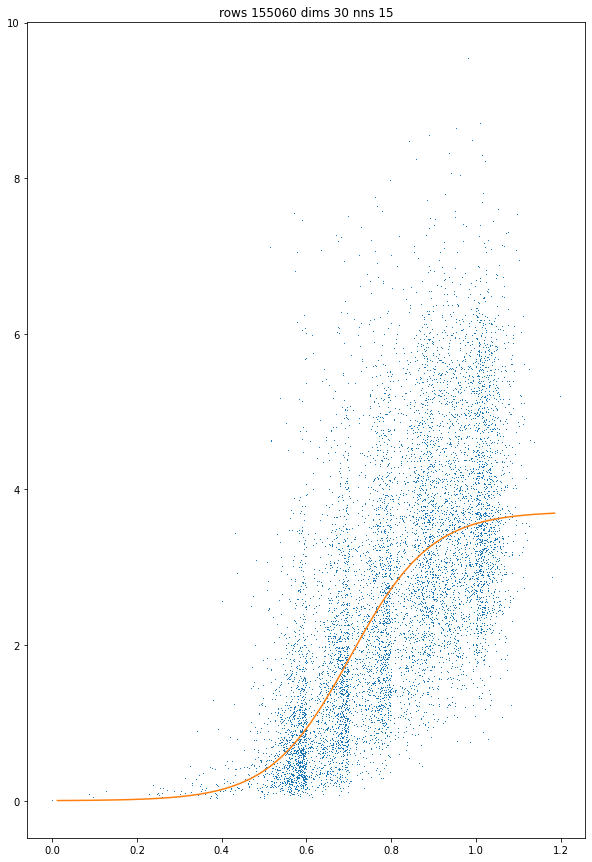

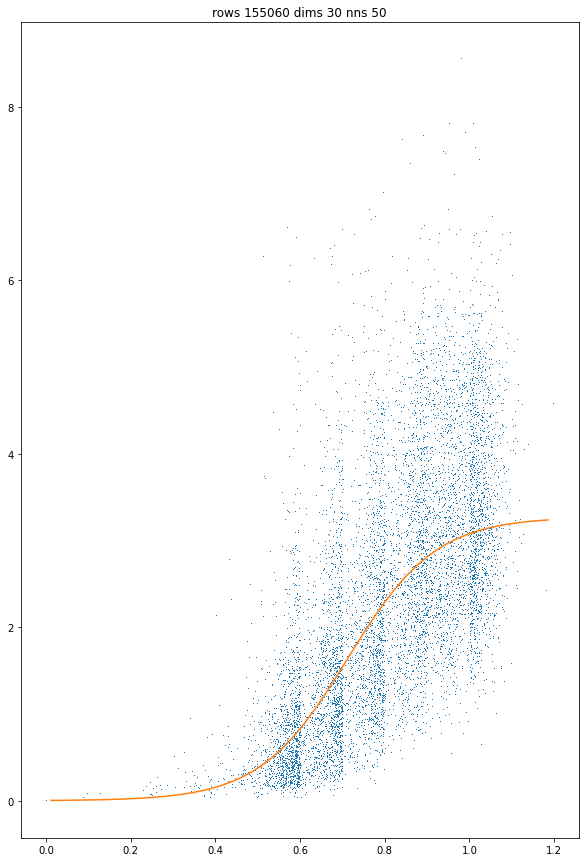

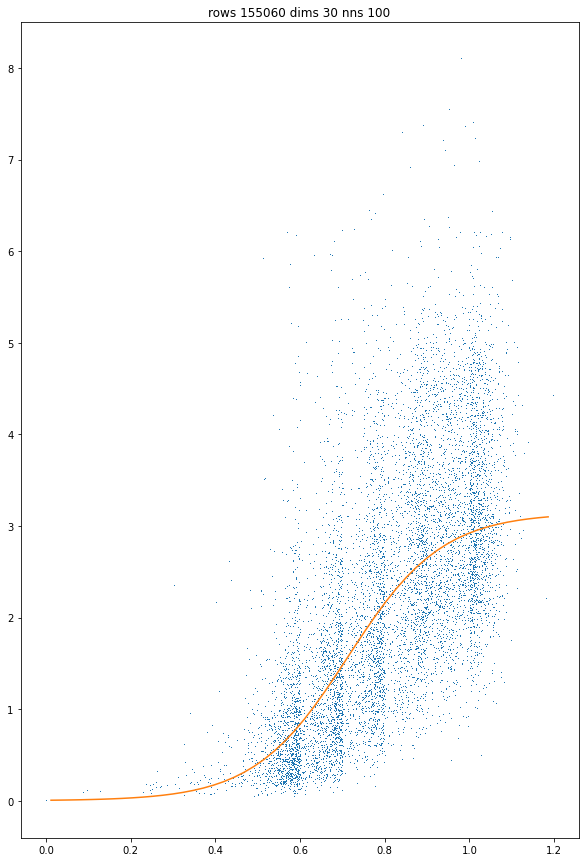

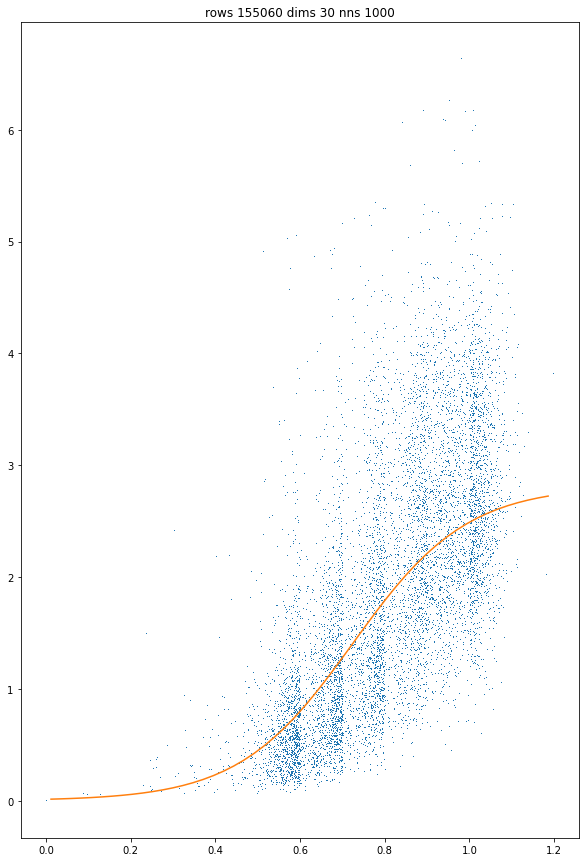

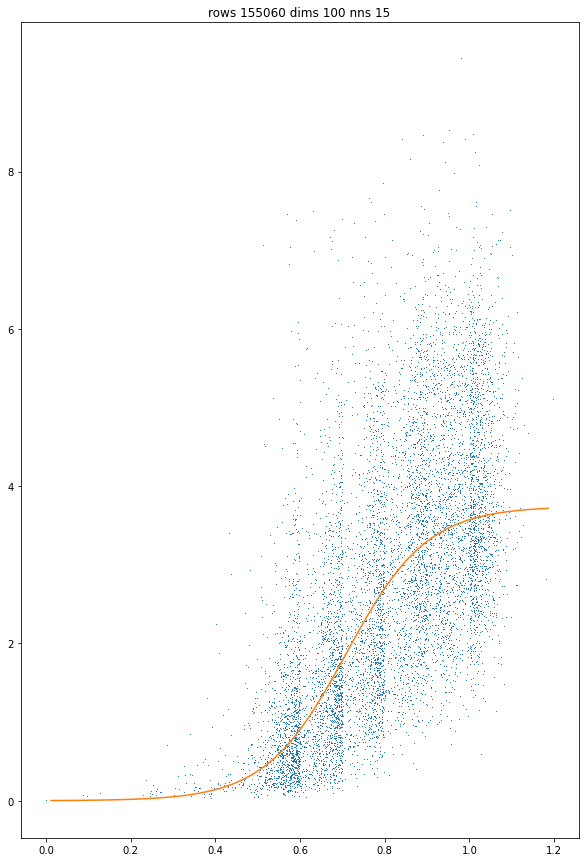

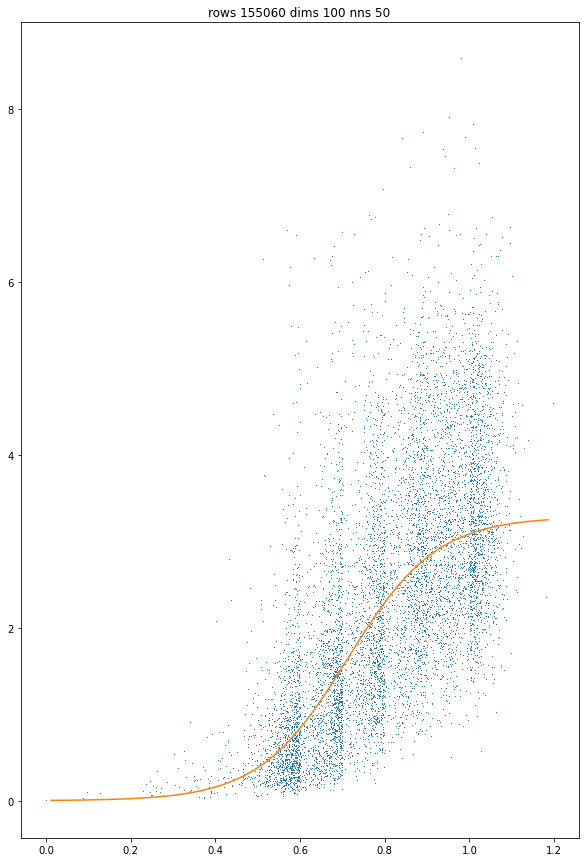

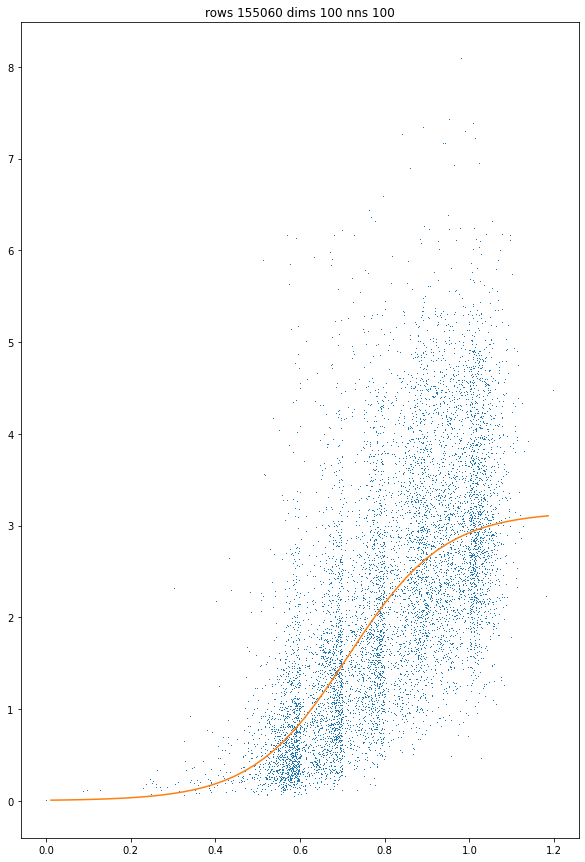

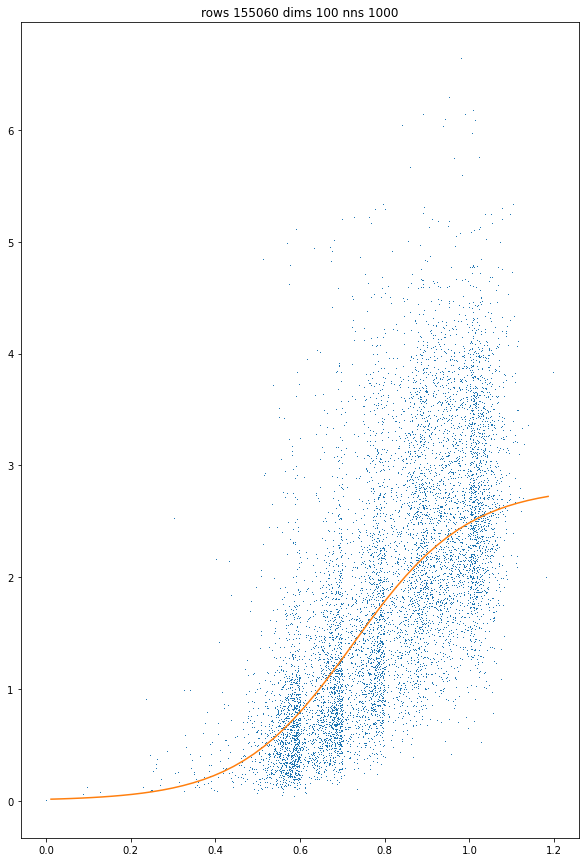

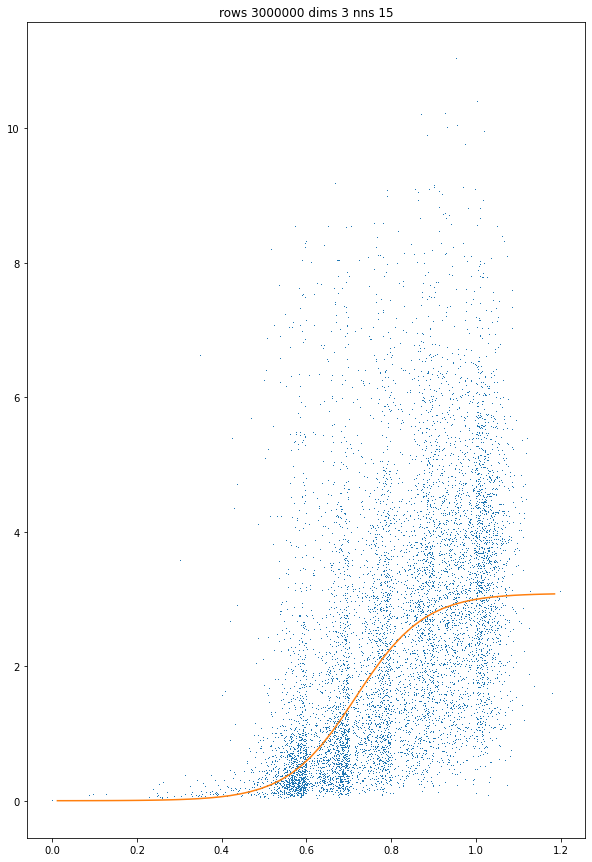

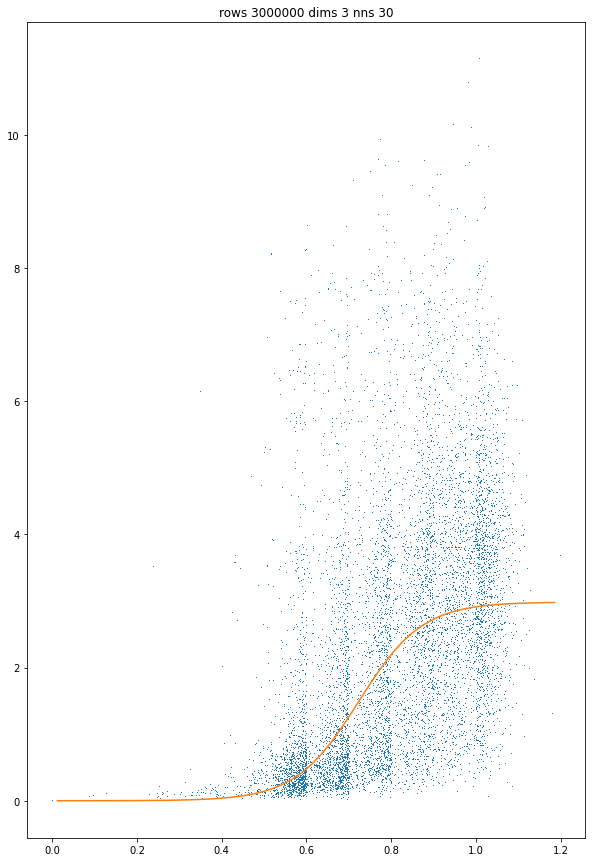

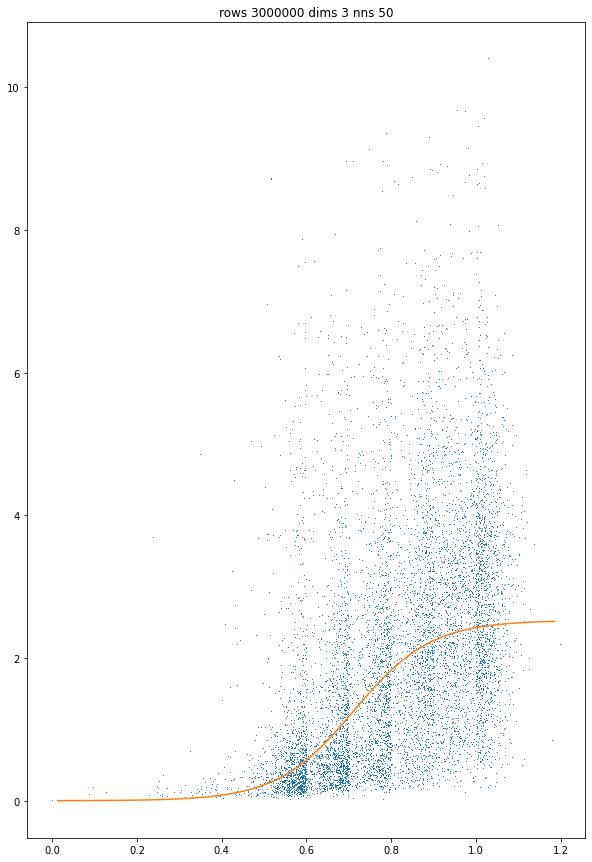

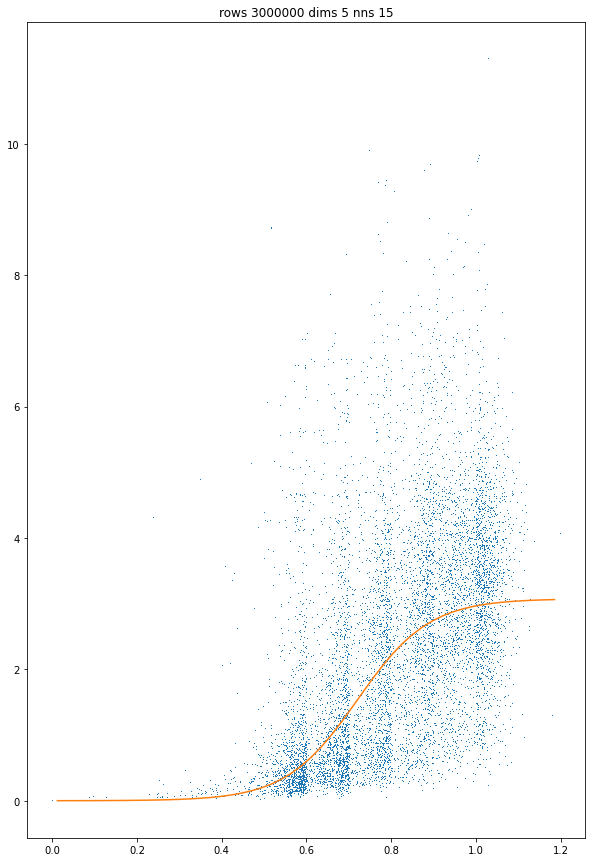

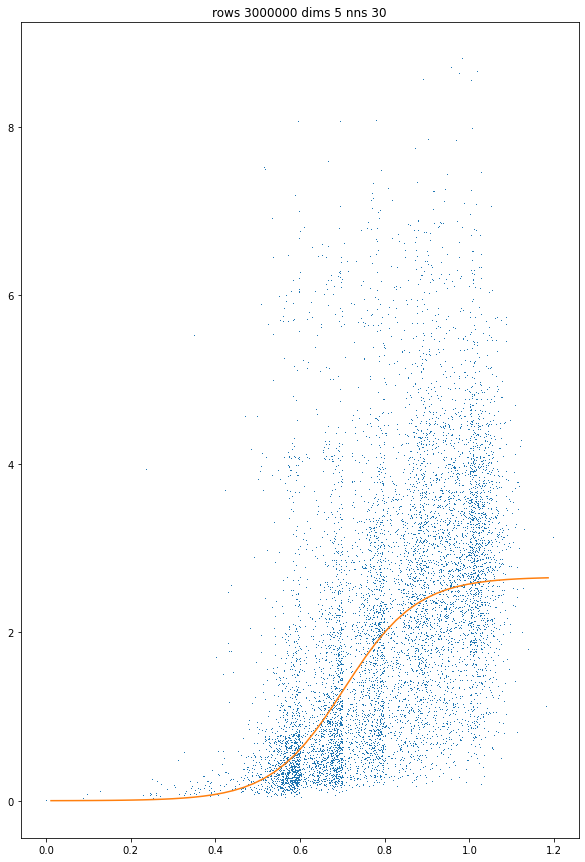

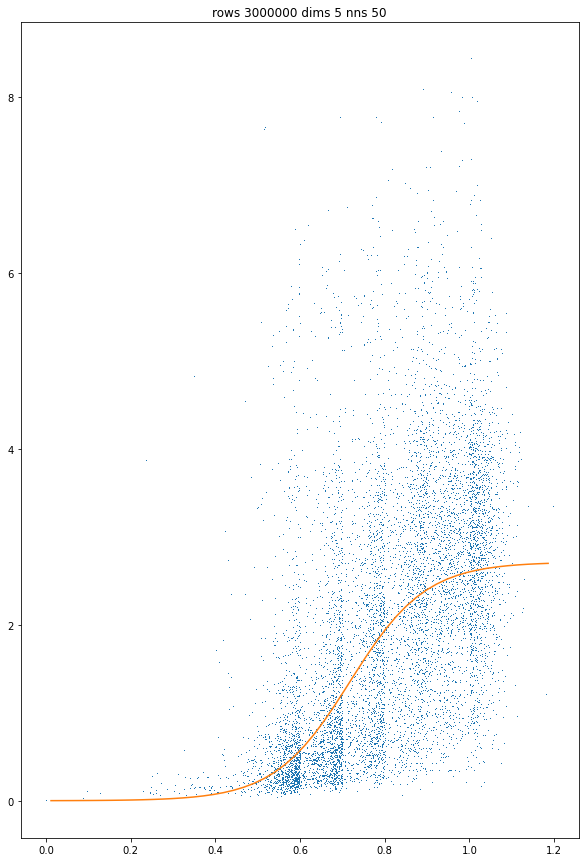

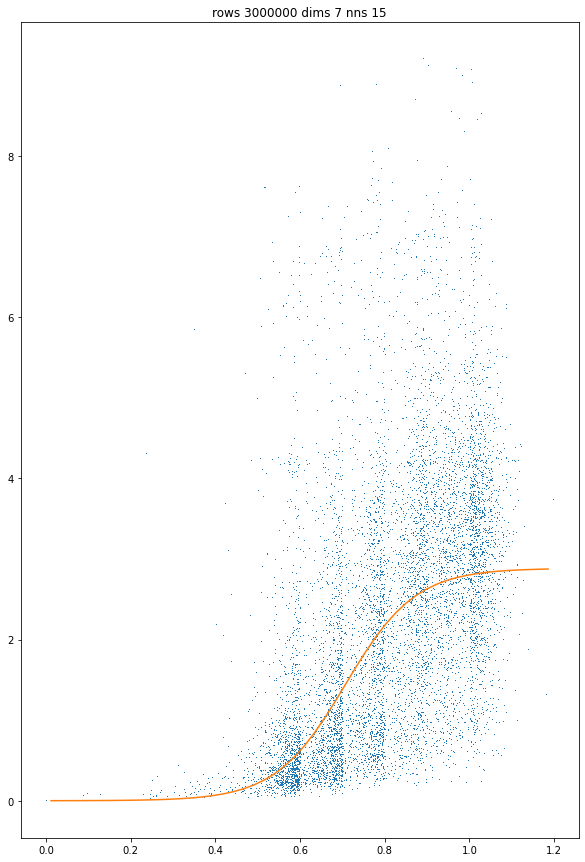

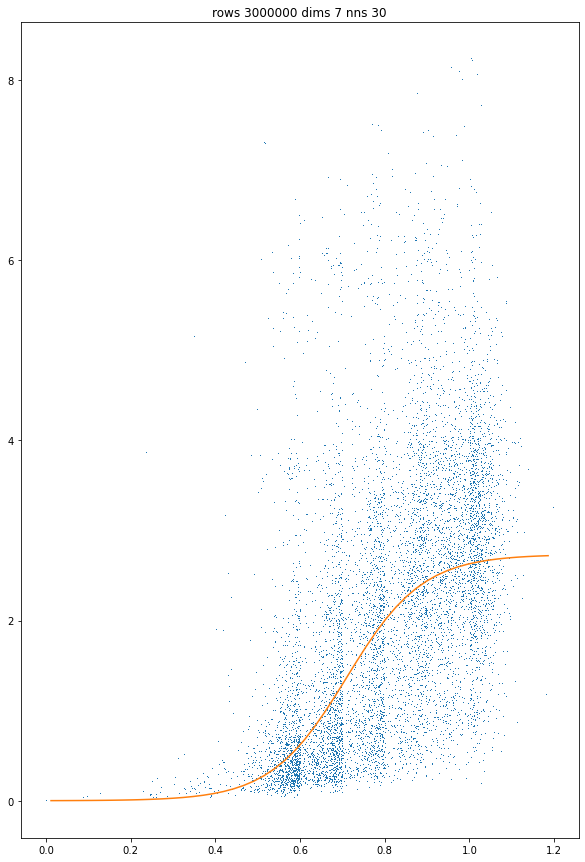

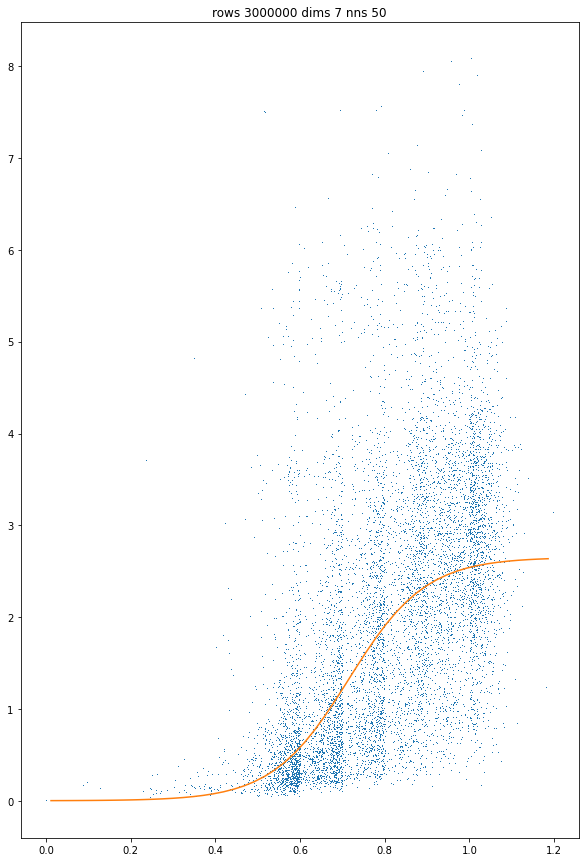

In [197]:
@dataclasses.dataclass
class UMAPFile():
    name: str
    rows: int
    dims: int
    nns: int
    curve: list

fns = []
for fn in os.listdir(DATA_DIR):
    if not fn.startswith('umap_'):
        continue
    if 'sphere' in fn:
        continue
    rows = int(re.search('_(\d+)rows', fn).group(1))
    dims = int(re.search('_(\d+)dims', fn).group(1))
    nns = int(re.search('_(\d+)nns', fn).group(1))
    fns.append(UMAPFile(name=DATA_DIR+fn, rows=rows, dims=dims, nns=nns, curve=[]))

fns.sort(key = lambda f: f.nns)
fns.sort(key = lambda f: f.dims)
fns.sort(key = lambda f: f.rows)


# plot each file
for fn in fns:
    if fn.dims==2:
        continue
    mat = np.load(fn.name)
    cos_dists = np.array([wp.dist for wp in word_pairs_cos])
    if fn.rows != len(w_list):
        w_fn = DATA_DIR+'w_list_{}.pkl'.format(fn.rows)
        with open(w_fn, 'rb') as fh:
            w_list = pickle.load(fh)
    eu_dists = get_eu_dists(word_pairs_cos, w_list, mat)
    
    bin_points, curve = do_curve_fit(cos_dists, eu_dists)
    fn.curve = curve
    fit_dists = [curve_func(d, curve[0], curve[1], curve[2]) for d in bin_points]
    plt.figure(figsize=(10,15))
    plt.plot(cos_dists, eu_dists, ',')
    plt.plot(bin_points, fit_dists, '-')
    plt.title('rows {} dims {} nns {}'.format(fn.rows, fn.dims, fn.nns))    
    plt.show()

with open(DATA_DIR + 'umap_curves.pkl', 'wb') as fh:
    pickle.dump(fns, fh)

In [198]:
fns

[UMAPFile(name='/mnt/Spookley/datasets/semantle/umap_155060rows_2dims_15nns.npy', rows=155060, dims=2, nns=15, curve=[]),
 UMAPFile(name='/mnt/Spookley/datasets/semantle/umap_155060rows_2dims_50nns.npy', rows=155060, dims=2, nns=50, curve=[]),
 UMAPFile(name='/mnt/Spookley/datasets/semantle/umap_155060rows_2dims_100nns.npy', rows=155060, dims=2, nns=100, curve=[]),
 UMAPFile(name='/mnt/Spookley/datasets/semantle/umap_155060rows_2dims_500nns.npy', rows=155060, dims=2, nns=500, curve=[]),
 UMAPFile(name='/mnt/Spookley/datasets/semantle/umap_155060rows_2dims_1000nns.npy', rows=155060, dims=2, nns=1000, curve=[]),
 UMAPFile(name='/mnt/Spookley/datasets/semantle/umap_155060rows_3dims_15nns.npy', rows=155060, dims=3, nns=15, curve=array([ 4.16850034, 11.36887909,  0.71787305])),
 UMAPFile(name='/mnt/Spookley/datasets/semantle/umap_155060rows_3dims_50nns.npy', rows=155060, dims=3, nns=50, curve=array([ 3.76140246, 10.0988936 ,  0.73140902])),
 UMAPFile(name='/mnt/Spookley/datasets/semantle/um

In [ ]:
def plot_dist_relationship(cos_dists, eu_dists_pca, eu_dists_umap, eu_dists_hybrid, nns, n_dims):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,)
    fig.set_figwidth(15)
    fig.suptitle('n_dims={}, nns={}'.format(n_dims, nns, ))
    
    # umap alone
    ax1.plot(cos_dists, eu_dists_umap, ',')
    corr = np.corrcoef(cos_dists, eu_dists_umap)[0,1]
    ax1.title.set_text('umap only, corr={}'.format(round(corr, 3)))
    
    # pca alone
    ax2.plot(cos_dists, eu_dists_pca, ',')
    corr = np.corrcoef(cos_dists, eu_dists_pca)[0,1]
    ax2.title.set_text( 'pca only, corr={}'.format(round(corr, 3)) )
 
    # hybrid
    ax3.plot(cos_dists, eu_dists_hybrid, ',')
    corr = np.corrcoef(cos_dists, eu_dists_hybrid)[0,1]
    ax3.title.set_text('hybrid, corr={}'.format(round(corr, 3)))
    
    plt.show()

In [ ]:
def blend_umap_pca(mat_umap, mat_pca, umap_weight=4):
    """
    # for some reason this is bad
    s = StandardScaler(with_std=False)
    mat_pca_scaled = s.fit_transform(mat_pca)
    mat_umap_scaled = s.fit_transform(mat_umap)
    hybrid_mat = np.hstack([mat_umap_normed, mat_pca_scaled])
    """
    # but this shit works well?!
    mat_pca_scaled = normalize(mat_pca, axis=1)
    mat_umap_scaled = normalize(mat_umap, axis=1)*umap_weight
    hybrid_mat = np.hstack([mat_umap_normed, mat_pca_scaled])
    
    return hybrid_mat

In [ ]:
def scale_dists(dists):
    min_dist = min(dists)
    max_dist = max(dists)
    range_ = max_dist - min_dist
    dists_scaled = []
    for d in dists:
        dists_scaled.append((d-min_dist) / range_)
    return dists_scaled

eu_dists_umap = dc.get_eu_dists(mat_umap_std)
eu_dists_umap = scale_dists(eu_dists_umap)

for pca_dims in [30, 50, 100]:
    mat_pca = do_pca(mat_full_normed, n_dims=pca_dims)
    mat_pca = s.fit_transform(mat_pca)

    cos_dists = dc.cos_dists
    eu_dists_pca = dc.get_eu_dists(mat_pca)
    eu_dists_pca = scale_dists(eu_dists_pca)
    
    eu_dists_hybrid = []
    for i in range(len(eu_dists_pca)):
        if dc.cos_dists[i] < 0.5:
            eu_dists_hybrid.append(eu_dists_umap[i])
        elif dc.cos_dists[i] < 0.8:
            eu_dists_hybrid.append(eu_dists_umap[i]*0.5 + eu_dists_pca[i]*0.5)
        else:
            eu_dists_hybrid.append(eu_dists_pca[i])

    plot_dist_relationship(cos_dists, eu_dists_pca, eu_dists_umap, eu_dists_hybrid, 10, pca_dims)

In [ ]:
plot_dist_relationship(cos_dists, eu_dists_pca, eu_dists_umap, eu_dists_hybrid, nns, n_dims)